## Run this tutorial with the **nnpcg_dev** environment

### Importing libraries

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from nnpcg.trainer import EasyTrainer

### Step 1: Preparing the dataset

In [7]:
# modify the next variable with the path to the folder where you cloned the repository
path_to_repo = '/home/dpastor/Dropbox (Biocomputing)/GitHub/projects/nnpcg'

# defining the path to the training data
training_data_folder = os.path.join(path_to_repo, 'nnpcg/data/training_data')

# loading the training data
cgnpp_test = EasyTrainer(pdb_file=os.path.join(training_data_folder, 'chignolin_cln025.pdb'), psf_file=os.path.join(training_data_folder, 'chignolin_ca_top.psf'), coords_array=os.path.join(training_data_folder, 'chignolin_ca_coords.npy'))

2023-04-18 09:28:30,528 - moleculekit.molecule - INFO - Removed 83 atoms. 10 atoms remaining in the molecule.


### Step 2: Calculating harmonic and repulsive terms for the prior forces

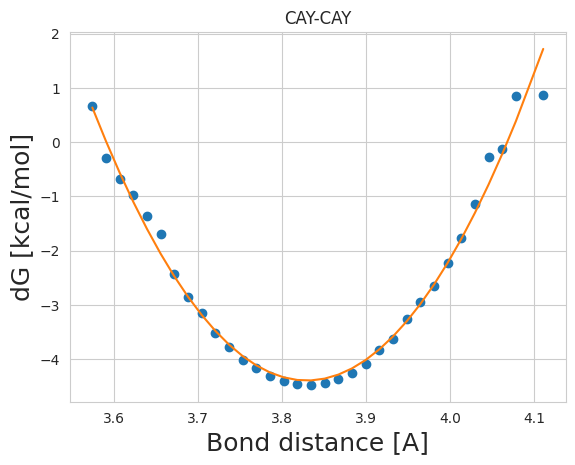

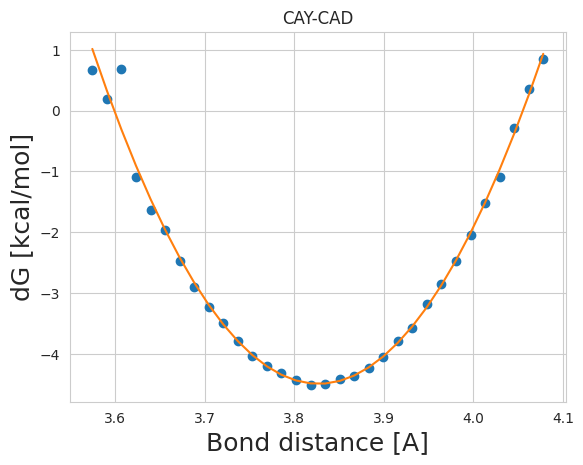

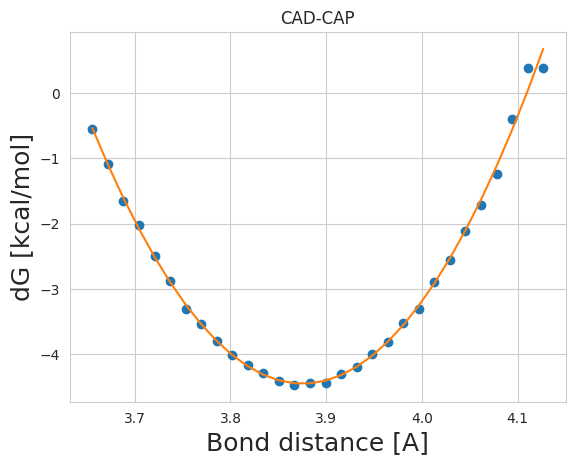

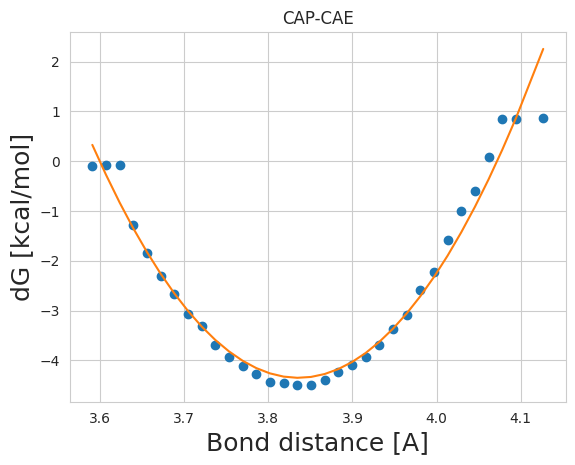

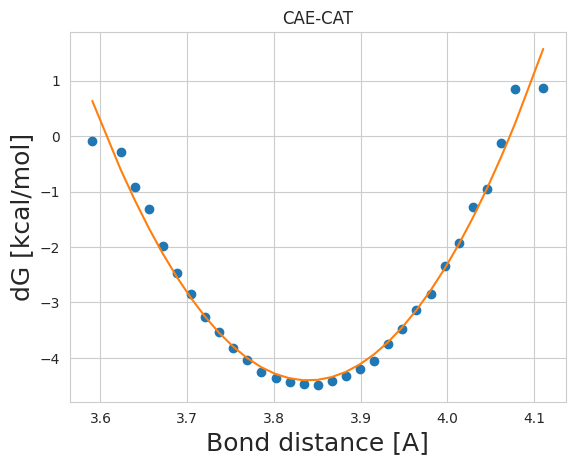

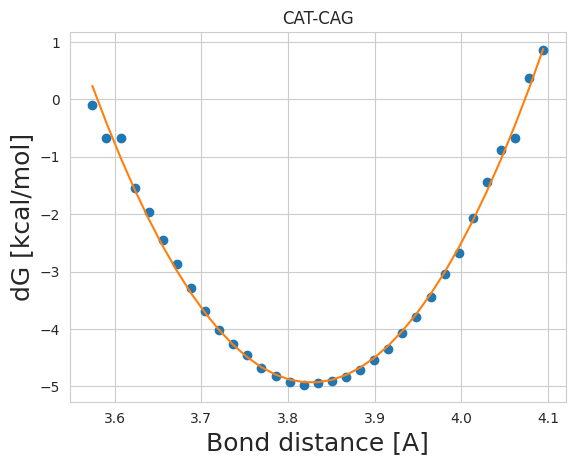

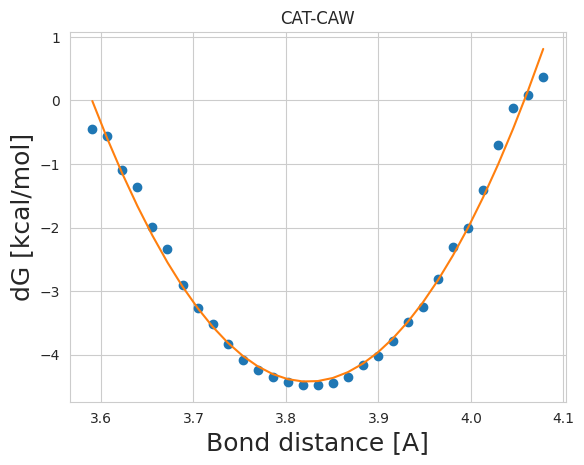

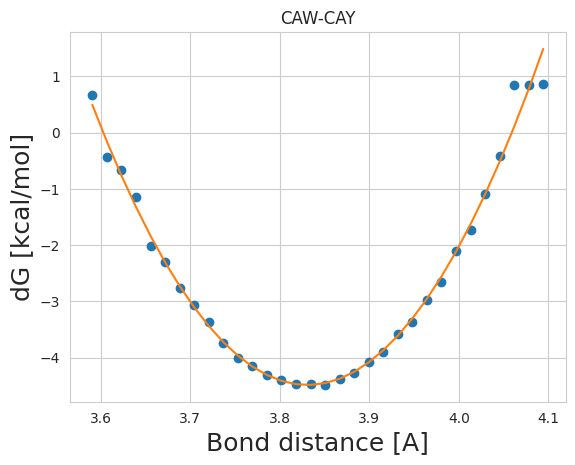

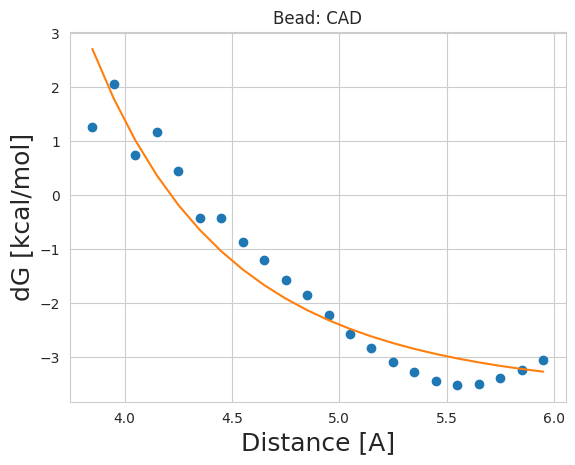

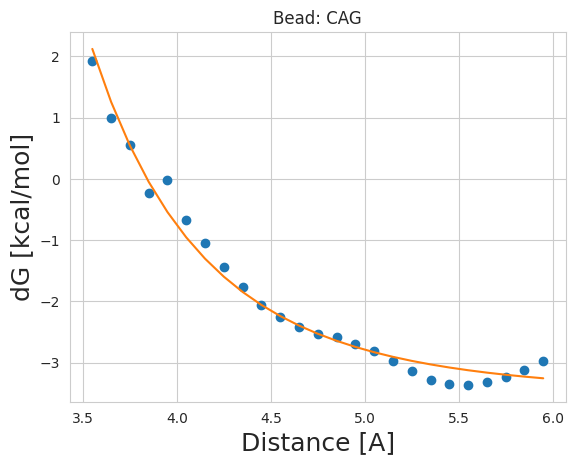

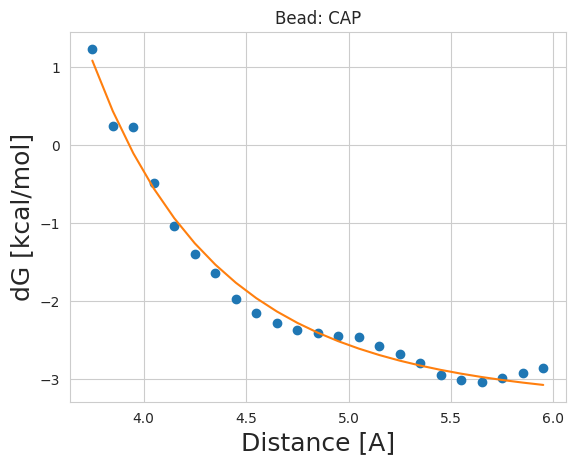

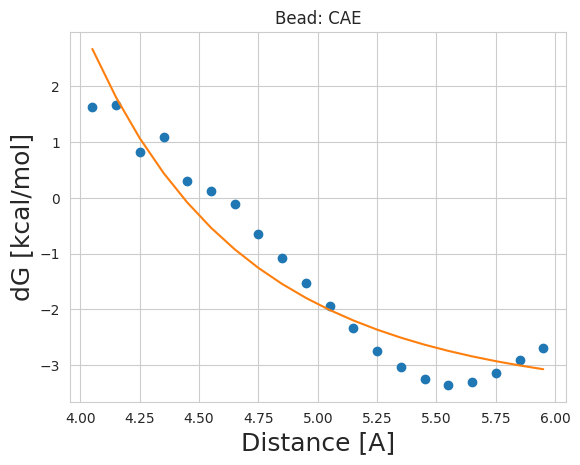

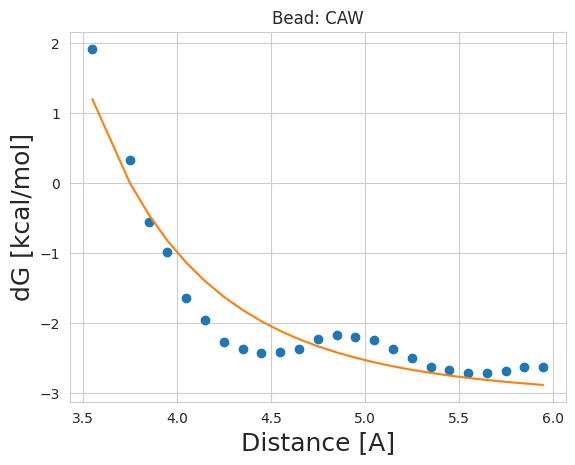

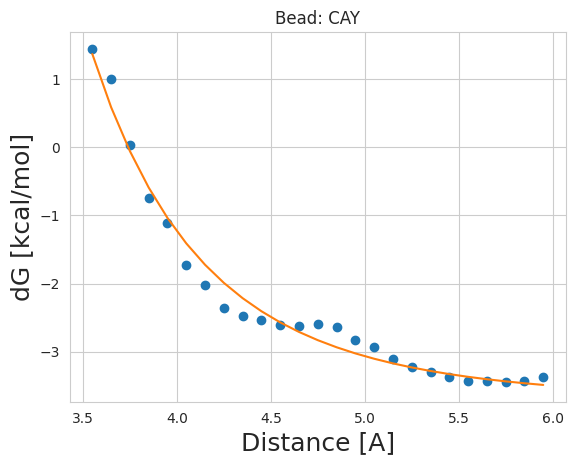

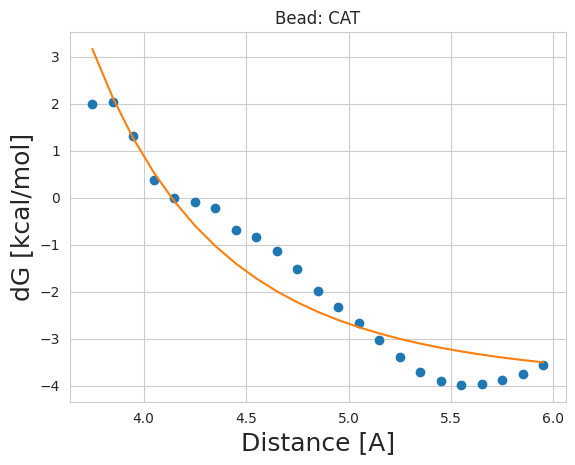

In [8]:
# fitting bonded parameters
cgnpp_test.fit_bonded_params(temperature=350, fit_range=[3.55, 4.2])

# fitting non-bonded parameters
cgnpp_test.fit_nonbonded_params(temperature=350, fit_range=[3, 6])

### Step 3: Writing prior forces to force field

In [9]:
# writing the forcefield
cgnpp_test.write_forcefield(ff_file=os.path.join(training_data_folder, 'forcefield_priors.yaml'))

### Step 4: Preparing delta-forces to train the CG NNP

In [10]:
# calculating the deltaforces
cgnpp_test.calculate_deltaforces(
    forces=os.path.join(training_data_folder, 'chignolin_ca_forces.npy'), 
    forcefield=os.path.join(training_data_folder, 'forcefield_priors.yaml'),
    deltaforces=os.path.join(training_data_folder, 'chignolin_ca_deltaforces.npy'),
    )

Check for broken coords.


100%|██████████| 9/9 [00:00<00:00, 1226.48it/s]

No broken frames



/home/dpastor/Documents/programs/anaconda3/envs/nnpcg_dev/lib/python3.9/site-packages/torchmd/systems.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pos[:] = torch.tensor(
/home/dpastor/Documents/programs/anaconda3/envs/nnpcg_dev/lib/python3.9/site-packages/torchmd/systems.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.box[r][torch.eye(3).bool()] = torch.tensor(


Producing delta forces


100%|██████████| 18689/18689 [00:14<00:00, 1265.47it/s]


### Step 5: Generating embeddings

In [11]:
# defining embeddings
AA2INT = {'ALA':1,
         'GLY':2,
         'PHE':3,
         'TYR':4,
         'ASP':5,
         'GLU':6,
         'TRP':7,
         'PRO':8,
         'ASN':9,
         'GLN':10,
         'HIS':11,
         'HSD':11,
         'HSE':11,
         'SER':12,
         'THR':13,
         'VAL':14,
         'MET':15,
         'CYS':16,
         'NLE':17,
         'ARG':18,
         'LYS':19,
         'LEU':20,
         'ILE':21
         }

# writing file  with embeddings
cgnpp_test.generate_embeddings(AA2INT, embedding_file=os.path.join(training_data_folder, 'chignolin_ca_embeddings.npy'))

### Step 6: Trainnig the CG NNP from the command-line

In [12]:
# printing command to train the CG NNP from the command line
cgnpp_test.train_command()

Please run the following command in a terminal with the proper python env:
python train.py --conf train.yaml --log-dir data/train_light


### \<Monitoring the training process\>

Text(0, 0.5, 'learning rate')

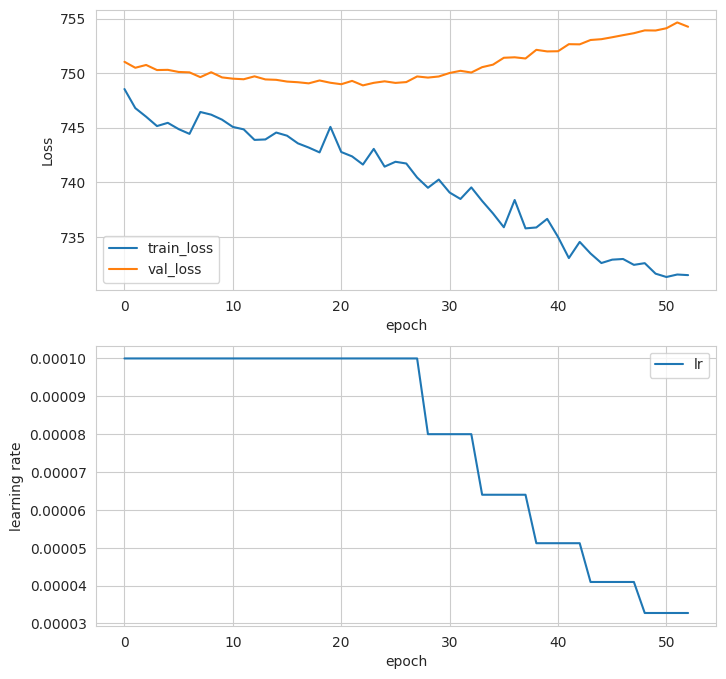

In [13]:
# loading file with parameters for the training
df = pd.read_csv(os.path.join(path_to_repo, 'nnpcg/data/train_light/metrics.csv'))

# plotting evolution of: i- the train and validation losses; and ii- the learning rate
fig, ax = plt.subplots(nrows = 2, figsize = [8,8])
df.plot(x = 'epoch', y = ['train_loss', 'val_loss'], ax = ax[0])
ax[0].set_ylabel('Loss')
df.plot(x = 'epoch', y = 'lr', ax = ax[1])
ax[1].set_ylabel('learning rate')